In [1]:
from kokoro import KModel
from kokoro_orig import KModel as KModel_orig
import torch
from misaki import en
import numpy as np
import os
import IPython.display as ipd
import torch.nn.utils.rnn as rnn


/home/azureuser/miniconda3/envs/kokoro_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(audio, sample_rate=22050):
    """
    Plot audio waveform
    
    Args:
        audio: PyTorch tensor or numpy array of audio samples
        sample_rate: Sample rate of the audio
    """
    # Convert to numpy if it's a tensor
    if torch.is_tensor(audio):
        audio = audio.detach().cpu().numpy()
    
    # Create time axis
    time = np.arange(0, len(audio)) / sample_rate
    
    plt.figure(figsize=(12, 4))
    plt.plot(time, audio, linewidth=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Audio Waveform')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    

In [3]:
def load_bin_voice(voice_path: str) -> torch.Tensor:
    """
    Load a .bin voice file as a PyTorch tensor.
    
    Args:
        voice_path: Path to the .bin voice file
        
    Returns:
        PyTorch tensor containing the voice data
    """
    if not os.path.exists(voice_path):
        raise FileNotFoundError(f"Voice file not found: {voice_path}")
    
    if not voice_path.endswith('.bin'):
        raise ValueError(f"Expected a .bin file, got: {voice_path}")
    
    # Load the binary file as a numpy array of float32 values
    voice_data = np.fromfile(voice_path, dtype=np.float32).reshape(-1, 1, 256)
    # Convert to PyTorch tensor
    voice_tensor = torch.tensor(voice_data, dtype=torch.float32)
    
    # Return the tensor
    return voice_tensor

In [4]:
# Initialize pipeline with American English
g2p = en.G2P(trf=False, british=False, fallback=None, unk='')

# Example 1: Using the pipeline with a voice name
text = [
    "This is a test!",
    "This is a test! I'm going to the store.",
]
model = KModel(repo_id="hexgrad/Kokoro-82M").to("cpu").eval()
ref_s = load_bin_voice("kokoro.js/voices/af_heart.bin")
input_id_tensors = []
style_tensors = []

for t in text:
    ps, mtoks = g2p(t)
    toks = list(filter(lambda i: i is not None, map(lambda p: model.vocab.get(p), ps)))
    input_id_tensors.append(torch.tensor([0,*toks,0], dtype=torch.long))
    style_tensors.append(ref_s[len(toks)-1][None,:,:])
input_lengths = torch.tensor([toks.shape[0] for toks in input_id_tensors], dtype=torch.long)
style_tensor = torch.cat(style_tensors, dim=0)
input_ids = rnn.pad_sequence(input_id_tensors, batch_first=True, padding_value=0)
print(input_lengths, style_tensor.shape, input_ids.shape)

/home/azureuser/miniconda3/envs/kokoro_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/home/azureuser/miniconda3/envs/kokoro_env/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


tensor([18, 41]) torch.Size([2, 1, 256]) torch.Size([2, 41])


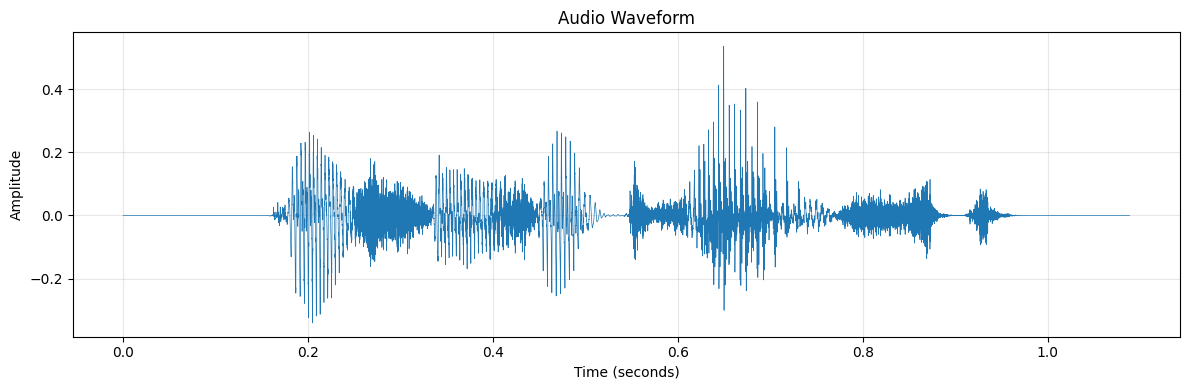

In [5]:
model_orig = KModel_orig(repo_id="hexgrad/Kokoro-82M").to("cpu").eval()
audio , _ = model_orig.forward_with_tokens(input_ids[0][None,:], style_tensor[0], 1.0)
plot_waveform(audio[6000:30000])
ipd.Audio(audio, rate=24000)

x shape: torch.Size([2, 41, 512]), s shape: torch.Size([2, 1, 128])
x shape: torch.Size([2, 41, 512]), s shape: torch.Size([2, 1, 128])
x shape: torch.Size([2, 41, 512]), s shape: torch.Size([2, 1, 128])


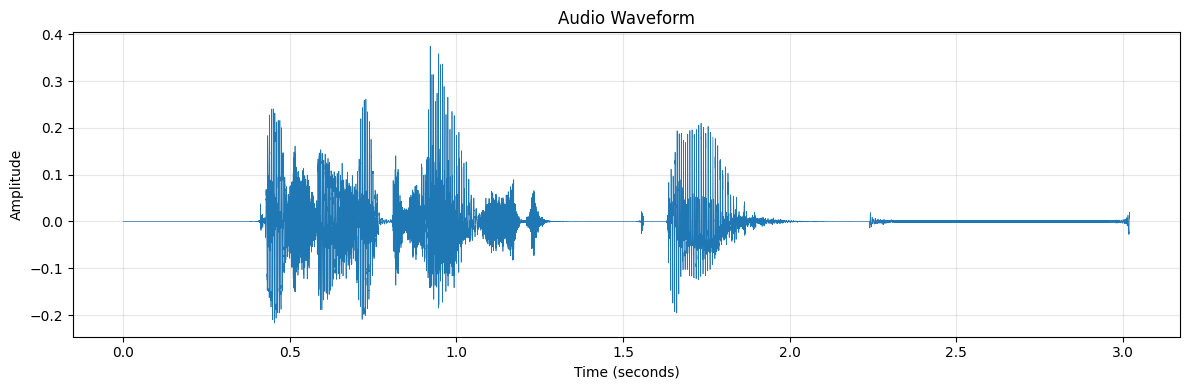

In [6]:
audio = model.forward_with_tokens(input_ids, style_tensor, 1.0,input_lengths)
plot_waveform(audio[0])
ipd.Audio(audio[1], rate=24000)

In [7]:
import onnxruntime as ort
model_fp32 = "./onnx_models/kokoro_batched_preprocess.onnx"
sess = ort.InferenceSession(model_fp32)

outputs = sess.run(None, {
    'input_ids': input_ids.numpy(),
    'style': style_tensor.numpy(),
    'speed': np.array([1.0], dtype=np.float32),
    'input_lengths': input_lengths.numpy()
})



NoSuchFile: [ONNXRuntimeError] : 3 : NO_SUCHFILE : Load model from ./onnx_models/kokoro_batched_preprocess.onnx failed:Load model ./onnx_models/kokoro_batched_preprocess.onnx failed. File doesn't exist

In [ ]:
ipd.Audio(outputs[0][1], rate=24000)